## Imports

In [1]:
from pyspark.sql import DataFrame, functions as F
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, BooleanType, LongType, DoubleType, ArrayType, DateType
from matplotlib import pyplot as plt
import seaborn as sns
from pyspark.sql.types import ArrayType, StringType, MapType, IntegerType
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, BucketedRandomProjectionLSH, BucketedRandomProjectionLSHModel, MinHashLSH, MinHashLSHModel, CountVectorizer, VectorAssembler
from pyspark.ml import Pipeline

## Create Spark session

In [2]:
from dtu_ctfds_02807_proj.context_creation import create_context

local = True
sc, spark = create_context(local)

Cell has not been executed before, running...


24/11/30 22:12:48 WARN Utils: Your hostname, macbook.local resolves to a loopback address: 127.0.0.1; using 192.168.86.58 instead (on interface en0)
24/11/30 22:12:48 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/30 22:12:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Load data

In [3]:
review_schema = StructType([
    StructField("index", IntegerType(), True),
    StructField("app_id", LongType(), True),
    StructField("app_name", StringType(), True),
    StructField("review_id", LongType(), True),
    StructField("language", StringType(), True),
    StructField("review", StringType(), True),
    StructField("timestamp_created", IntegerType(), True),
    StructField("timestamp_updated", IntegerType(), True),
    StructField("recommended", BooleanType(), True),
    StructField("votes_helpful", IntegerType(), True),
    StructField("votes_funny", IntegerType(), True),
    StructField("weighted_vote_score", DoubleType(), True),
    StructField("comment_count", IntegerType(), True),
    StructField("steam_purchase", BooleanType(), True),
    StructField("received_for_free", BooleanType(), True),
    StructField("written_during_early_access", BooleanType(), True),
    StructField("author_steamid", LongType(), True),
    StructField("author_num_games_owned", IntegerType(), True),
    StructField("author_num_reviews", IntegerType(), True),
    StructField("author_playtime_forever", DoubleType(), True),
    StructField("author_playtime_last_two_weeks", DoubleType(), True),
    StructField("author_playtime_at_review", DoubleType(), True),
    StructField("author_last_played", DoubleType(), True)
])

In [4]:
game_schema = StructType([
    StructField("app_id", IntegerType(), True),
    StructField("name", StringType(), True),
    StructField("release_date", DateType(), True),
    StructField("required_age", IntegerType(), True),
    StructField("price", FloatType(), True),
    StructField("dlc_count", IntegerType(), True),
    StructField("detailed_description", StringType(), True),
    StructField("about_the_game", StringType(), True),
    StructField("short_description", StringType(), True),
    StructField("reviews", StringType(), True),
    StructField("header_image", StringType(), True),
    StructField("website", StringType(), True),
    StructField("support_url", StringType(), True),
    StructField("support_email", StringType(), True),
    StructField("windows", BooleanType(), True),
    StructField("mac", BooleanType(), True),
    StructField("linux", BooleanType(), True),
    StructField("metacritic_score", IntegerType(), True),
    StructField("metacritic_url", StringType(), True),
    StructField("achievements", IntegerType(), True),
    StructField("recommendations", IntegerType(), True),
    StructField("notes", StringType(), True),
    StructField("supported_languages", ArrayType(StringType()), True),  # Parsed from JSON
    StructField("full_audio_languages", ArrayType(StringType()), True),  # Parsed from JSON
    StructField("packages", ArrayType(StringType()), True),  # Parsed from JSON
    StructField("developers", ArrayType(StringType()), True),  # Parsed from JSON
    StructField("publishers", ArrayType(StringType()), True),  # Parsed from JSON
    StructField("categories", ArrayType(StringType()), True),  # Parsed from JSON
    StructField("genres", ArrayType(StringType()), True),  # Parsed from JSON
    StructField("screenshots", ArrayType(StringType()), True),  # Parsed from JSON
    StructField("movies", ArrayType(StringType()), True),  # Parsed from JSON
    StructField("user_score", FloatType(), True),
    StructField("score_rank", IntegerType(), True),
    StructField("positive", IntegerType(), True),
    StructField("negative", IntegerType(), True),
    StructField("estimated_owners", StringType(), True),
    StructField("average_playtime_forever", IntegerType(), True),
    StructField("average_playtime_2weeks", IntegerType(), True),
    StructField("median_playtime_forever", IntegerType(), True),
    StructField("median_playtime_2weeks", IntegerType(), True),
    StructField("peak_ccu", IntegerType(), True),
    StructField("tags", MapType(StringType(), IntegerType()), True),  # Parsed from JSON
    StructField("pct_pos_total", IntegerType(), True),
    StructField("num_reviews_total", IntegerType(), True),
    StructField("pct_pos_recent", IntegerType(), True),
    StructField("num_reviews_recent", IntegerType(), True)
])

In [5]:

if local:
    game_reviews = spark.read.parquet("data/steam_reviews_sample_parquet")
    games = spark.read.parquet("data/steam_games_parquet")
else:
    game_reviews = spark.read.parquet("file:////work/ds/steam_reviews_parquet")
    games = spark.read.parquet('file:////work/ds/steam_games_parquet')
    

game_reviews: DataFrame = game_reviews.persist()
games: DataFrame = games.persist()

In [6]:
game_reviews\
    .select(game_reviews.app_id)\
    .distinct()\
    .count()

315

In [7]:
game_reviews\
    .show(5)

+-------+------+--------------------+---------+--------+----------------------------------+-----------------+-----------------+-----------+-------------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+-----------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+
|  index|app_id|            app_name|review_id|language|                            review|timestamp_created|timestamp_updated|recommended|votes_helpful|votes_funny|weighted_vote_score|comment_count|steam_purchase|received_for_free|written_during_early_access|   author_steamid|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_last_two_weeks|author_playtime_at_review|author_last_played|
+-------+------+--------------------+---------+--------+----------------------------------+-----------------+-----------------+-----------+-------------+-----

In [8]:
game_reviews\
    .select(game_reviews.app_id)\
    .filter(game_reviews.language == 'english')\
    .count()

46020

In [9]:
# Select users with more than 1 review

users_with_multiple_reviews = game_reviews\
    .groupBy(game_reviews.author_steamid)\
    .agg(
        F.count(game_reviews.review_id).alias('review_count')
    )\
    .filter(F.col('review_count') > 1)

users_with_multiple_reviews_reviews = users_with_multiple_reviews.join(game_reviews, on='author_steamid', how='inner')

users_with_multiple_reviews_reviews\
    .count()

1311

In [10]:
# users_with_multiple_reviews_reviews\
#     .write.parquet('ds/users_with_multiple_reviews_reviews_parquet', mode='overwrite')

## Most reviewed games

In [11]:
most_reviewed = game_reviews\
    .groupBy(game_reviews.app_id)\
    .agg(
        F.count('review_id').alias('review_count'),
        F.count(
            F.when(game_reviews.recommended == True, 1)
        ).alias('recommended_count'),
        F.count(
            F.when(game_reviews.recommended == False, 1)
        ).alias('not_recommended_count')
    )\
    .withColumn(
        'recommended_ratio',
        F.col('recommended_count') / F.col('review_count')
    )\
    .withColumn(
        'not_recommended_ratio',
        F.col('not_recommended_count') / F.col('review_count')
    )\
    .withColumn(
        'recommended_to_not_recommended_ratio',
        F.col('recommended_count') / F.col('not_recommended_count')
    )

most_reviewed_games = most_reviewed\
    .join(games, most_reviewed.app_id == games.app_id, how='inner')


In [12]:
most_reviewed_games\
    .select('name', 'review_count', 'recommended_ratio', 'recommended_to_not_recommended_ratio')\
    .orderBy(F.desc('review_count'))\
    .show(
        5,
        truncate=False
    )

+-------------------------------+------------+------------------+------------------------------------+
|name                           |review_count|recommended_ratio |recommended_to_not_recommended_ratio|
+-------------------------------+------------+------------------+------------------------------------+
|PUBG: BATTLEGROUNDS            |7835        |0.5392469687300574|1.1703601108033241                  |
|Grand Theft Auto V             |4913        |0.8155912884184816|4.422737306843267                   |
|Tom Clancy's Rainbow Six® Siege|3981        |0.8839487565938207|7.616883116883117                   |
|Terraria                       |3084        |0.9727626459143969|35.714285714285715                  |
|Garry's Mod                    |3079        |0.9600519649236765|24.03252032520325                   |
+-------------------------------+------------+------------------+------------------------------------+
only showing top 5 rows



In [13]:
most_reviewed_games\
    .select('name', 'review_count', 'recommended_ratio', 'recommended_to_not_recommended_ratio')\
    .filter(F.col('recommended_to_not_recommended_ratio').isNotNull())\
    .filter(F.col('review_count') > 100)\
    .orderBy(F.asc('recommended_to_not_recommended_ratio'))\
    .show(
        5,
        truncate=False
    )

+-------------------+------------+------------------+------------------------------------+
|name               |review_count|recommended_ratio |recommended_to_not_recommended_ratio|
+-------------------+------------+------------------+------------------------------------+
|ATLAS              |192         |0.4791666666666667|0.92                                |
|Call of Duty®: WWII|141         |0.524822695035461 |1.1044776119402986                  |
|PUBG: BATTLEGROUNDS|7835        |0.5392469687300574|1.1703601108033241                  |
|Artifact           |113         |0.5575221238938053|1.26                                |
|No Man's Sky       |896         |0.6796875         |2.1219512195121952                  |
+-------------------+------------+------------------+------------------------------------+
only showing top 5 rows



## Review count by user

In [14]:
reviews_by_user = game_reviews\
    .groupBy("author_steamid")\
    .agg(
        F.count('review_id').alias('review_count'),
    )

user_review_count = reviews_by_user\
    .groupBy("review_count")\
    .agg(
        F.count('review_count').alias('user_count'),
    )\
    .orderBy(F.desc('review_count'))

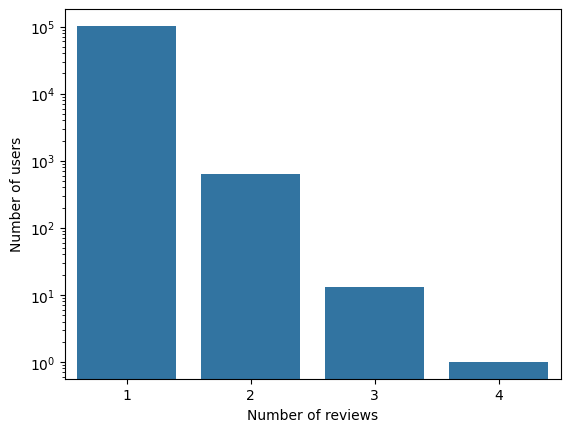

In [15]:
user_review_count_pd = user_review_count.toPandas()

# Only discrete values, log y-axis
sns.barplot(
    x=user_review_count_pd['review_count'],
    y=user_review_count_pd['user_count'],
    log=True
)
plt.xlabel('Number of reviews')
plt.ylabel('Number of users')

plt.show()

## Histogram of review_count

In [16]:
most_reviewed_games_pdf = most_reviewed_games.toPandas()

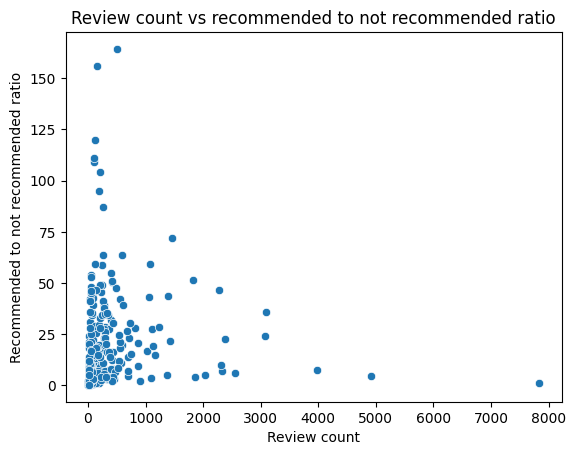

In [17]:
sns.scatterplot(
    x='review_count',
    y='recommended_to_not_recommended_ratio',
    data=most_reviewed_games_pdf
)

plt.xlabel('Review count')
plt.ylabel('Recommended to not recommended ratio')
plt.title('Review count vs recommended to not recommended ratio')
plt.show()

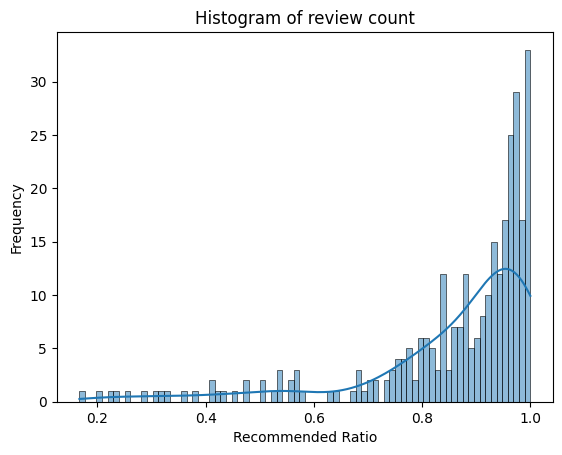

In [18]:
sns.histplot(
    most_reviewed_games_pdf['recommended_ratio'],
    bins=80,
    kde=True
)
plt.xlabel('Recommended Ratio')
plt.ylabel('Frequency')
plt.title('Histogram of review count')
plt.show()

In [19]:
game_reviews\
    .filter(game_reviews.author_steamid > 100)\
    .groupBy(game_reviews.app_id, game_reviews.author_steamid)\
    .agg(
        F.count('review_id').alias('review_count'),
    )\
    .orderBy(F.desc('review_count'))\
    .show(
        5
    )

+-------+-----------------+------------+
| app_id|   author_steamid|review_count|
+-------+-----------------+------------+
| 367520|76561198988312667|           2|
| 227300|76561198079793673|           2|
| 779340|76561198156707503|           1|
| 779340|76561198022192588|           1|
|1190460|76561198080232836|           1|
+-------+-----------------+------------+
only showing top 5 rows



# Collaborative filtering

In [20]:
from pyspark.ml.clustering import KMeans

features = [
    "recommended",
    "author_num_reviews",
    "author_playtime_forever",
    "weighted_vote_score",
]

# Assemble features into a single vector column
assembler = VectorAssembler(inputCols=features, outputCol="features")
feature_data = assembler.transform(game_reviews)

# Train KMeans model
kmeans = KMeans(k=5, seed=42, featuresCol="features", predictionCol="cluster")
model = kmeans.fit(feature_data)

# Assign clusters to users
clustered_data = model.transform(feature_data)

# Show sample cluster assignments
# clustered_data.select("author_steamid", "cluster").show()

# Analyze clusters for recommendations
# Example: Find top games in each cluster based on user reviews
top_games_per_cluster = (
    clustered_data
    .groupBy("cluster", "app_name")
    .count()
    .orderBy("cluster", "count", ascending=False)
    .groupBy("cluster")
    .agg(F.collect_list("app_name").alias("top_games"))
)

top_games_per_cluster.show(truncate=False)

# Save the model or clustered data if needed
# model.save("path_to_save_model")
# clustered_data.write.csv("path_to_clustered_data.csv", header=True)

+-------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [21]:
many_reviews_users = spark.read.parquet('data/many_reviews_users_parquet')


many_reviews_users.printSchema()

root
 |-- author_steamid: long (nullable = true)
 |-- review_count: long (nullable = true)
 |-- index: integer (nullable = true)
 |-- app_id: long (nullable = true)
 |-- app_name: string (nullable = true)
 |-- review_id: long (nullable = true)
 |-- language: string (nullable = true)
 |-- review: string (nullable = true)
 |-- timestamp_created: integer (nullable = true)
 |-- timestamp_updated: integer (nullable = true)
 |-- recommended: boolean (nullable = true)
 |-- votes_helpful: integer (nullable = true)
 |-- votes_funny: integer (nullable = true)
 |-- weighted_vote_score: double (nullable = true)
 |-- comment_count: integer (nullable = true)
 |-- steam_purchase: boolean (nullable = true)
 |-- received_for_free: boolean (nullable = true)
 |-- written_during_early_access: boolean (nullable = true)
 |-- author_num_games_owned: integer (nullable = true)
 |-- author_num_reviews: integer (nullable = true)
 |-- author_playtime_forever: double (nullable = true)
 |-- author_playtime_last_two

In [22]:
many_reviews_users = many_reviews_users\
    .withColumn(
        "author_playtime_at_review",
        F.when(
            F.col("author_playtime_at_review").isNull(),
            0
        ).otherwise(
            F.col("author_playtime_at_review")
        )
    )

Training KMeans for k=2


Training KMeans for k=3


Training KMeans for k=4


Training KMeans for k=5


Training KMeans for k=6


Training KMeans for k=7


Training KMeans for k=8


Training KMeans for k=9


Training KMeans for k=10


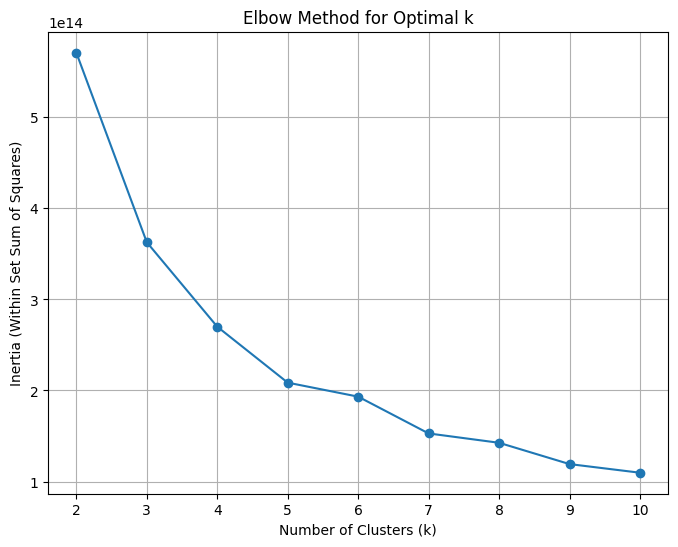

In [23]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler

features = [
    "recommended",
    "author_num_reviews",
    "author_playtime_at_review",
    "author_playtime_forever",
    "author_playtime_last_two_weeks",
]
assembler = VectorAssembler(inputCols=features, outputCol="features")
assembled_data = assembler.transform(many_reviews_users)

# Elbow method: Compute inertia for different k values
k_values = list(range(2, 11))  # Modify range as needed
inertia = []

for k in k_values:
    print(f"Training KMeans for k={k}")
    kmeans = KMeans(featuresCol="features", k=k, seed=42)
    model = kmeans.fit(assembled_data)
    predictions = model.transform(assembled_data)
    
    # Compute WSSSE (Within Set Sum of Squared Errors)
    rmse_evaluator = ClusteringEvaluator(predictionCol="prediction", featuresCol="features", metricName="silhouette")
    silhouette = rmse_evaluator.evaluate(predictions)
    inertia.append(model.summary.trainingCost)

# Plot the elbow method results
plt.figure(figsize=(8, 6))
plt.plot(k_values, inertia, marker="o")
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Within Set Sum of Squares)")
plt.grid()
plt.show()


## KMeans clustering

## ALS model

In [24]:
from pyspark.sql import Window
from pyspark.ml.recommendation import ALS
from pyspark.ml.feature import StringIndexer

In [25]:
many_reviews_users = spark.read.parquet('data/many_reviews_users_parquet')

game_ratings = many_reviews_users\
    .filter(F.col("author_steamid").isNotNull())\
    .withColumn(
        'rating',
        F.when(many_reviews_users.recommended == True, 1).otherwise(-1)
    )

user_indexer = StringIndexer(inputCol="author_steamid", outputCol="user_index")

game_ratings = user_indexer.fit(game_ratings).transform(game_ratings)

window_spec = Window\
    .partitionBy("author_steamid")\
    .orderBy(F.rand())

df_with_row_number = game_ratings\
    .withColumn('row_number', F.row_number().over(window_spec))

reviews_test = df_with_row_number\
    .filter(F.col('row_number') == 1)\
    .drop('row_number')\
    .cache()

reviews_train = df_with_row_number\
    .filter(F.col('row_number') > 1)\
    .drop('row_number')\
    .cache()

In [26]:
game_reviews.printSchema()

root
 |-- index: integer (nullable = true)
 |-- app_id: long (nullable = true)
 |-- app_name: string (nullable = true)
 |-- review_id: long (nullable = true)
 |-- language: string (nullable = true)
 |-- review: string (nullable = true)
 |-- timestamp_created: integer (nullable = true)
 |-- timestamp_updated: integer (nullable = true)
 |-- recommended: boolean (nullable = true)
 |-- votes_helpful: integer (nullable = true)
 |-- votes_funny: integer (nullable = true)
 |-- weighted_vote_score: double (nullable = true)
 |-- comment_count: integer (nullable = true)
 |-- steam_purchase: boolean (nullable = true)
 |-- received_for_free: boolean (nullable = true)
 |-- written_during_early_access: boolean (nullable = true)
 |-- author_steamid: long (nullable = true)
 |-- author_num_games_owned: integer (nullable = true)
 |-- author_num_reviews: integer (nullable = true)
 |-- author_playtime_forever: double (nullable = true)
 |-- author_playtime_last_two_weeks: double (nullable = true)
 |-- auth

In [27]:

implicit_als = ALS(
    maxIter=50,
    rank=20,
    regParam=0.01,
    userCol="user_index",
    itemCol="app_id",
    ratingCol="author_playtime_forever",
    coldStartStrategy="drop",
    implicitPrefs=True
)

In [28]:

explicit_als = ALS(
    maxIter=50,
    rank=20,
    regParam=0.01,
    userCol="user_index",
    itemCol="app_id",
    ratingCol="rating",
    coldStartStrategy="drop"
)

In [29]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

reviews_train = reviews_train.na.drop(subset=["user_index", "app_id", "rating"])

# Simple model for debugging
explicit_als = ALS(
    userCol="user_index",
    itemCol="app_id",
    ratingCol="rating",
    coldStartStrategy="drop"
)

# Simple example for debugging
param_grid = ParamGridBuilder() \
    .addGrid(explicit_als.maxIter, [20]) \
    .addGrid(explicit_als.rank, [20]) \
    .addGrid(explicit_als.regParam, [0.01]) \
    .build()

rmse_evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')

# Define CrossValidator
cv = CrossValidator(
    estimator=explicit_als,
    estimatorParamMaps=param_grid,
    evaluator=rmse_evaluator,
    numFolds=3,
)

# Fit the model
model = cv.fit(reviews_train)

In [30]:
from pyspark.ml.recommendation import ALSModel

# Extract the best model
explicit_model: ALSModel = model.bestModel

# Print parameters of the best model
print('Rank:', explicit_model.rank)
print('MaxIter:', explicit_model._java_obj.parent().getMaxIter())
print('RegParam:', explicit_model._java_obj.parent().getRegParam())

Rank: 20
MaxIter: 20
RegParam: 0.01


In [31]:
explicit_predictions = explicit_model.transform(reviews_test).cache()

In [32]:
implicit_model = implicit_als.fit(reviews_train)

implicit_predictions = implicit_model.transform(reviews_test).cache()

implicit_predictions\
    .show(5)

+-----------------+------------+--------+------+--------------------+---------+--------+--------------------+-----------------+-----------------+-----------+-------------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+------+----------+----------+
|   author_steamid|review_count|   index|app_id|            app_name|review_id|language|              review|timestamp_created|timestamp_updated|recommended|votes_helpful|votes_funny|weighted_vote_score|comment_count|steam_purchase|received_for_free|written_during_early_access|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_last_two_weeks|author_playtime_at_review|author_last_played|rating|user_index|prediction|
+-----------------+------------+--------+------+--------------------+---------+--------+------------

In [33]:
# Round predictions to -1 or 1
rounded_pred = explicit_predictions\
    .withColumn(
        'prediction',
        F.when(F.col('prediction') > 0, 1.).otherwise(-1.)
    )

rounded_pred.show(5)

+-----------------+------------+--------+------+--------------------+---------+--------+--------------------+-----------------+-----------------+-----------+-------------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+------+----------+----------+
|   author_steamid|review_count|   index|app_id|            app_name|review_id|language|              review|timestamp_created|timestamp_updated|recommended|votes_helpful|votes_funny|weighted_vote_score|comment_count|steam_purchase|received_for_free|written_during_early_access|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_last_two_weeks|author_playtime_at_review|author_last_played|rating|user_index|prediction|
+-----------------+------------+--------+------+--------------------+---------+--------+------------

In [37]:
reviews_by_user = reviews_train\
    .groupBy("author_steamid")\
    .agg(
        F.count('review_id').alias('review_count'),
    )

# get max review count
review_counts = reviews_by_user\
    .select('review_count')\
    .filter(F.col('review_count') < 50)\
    .distinct()\
    .toPandas()['review_count']

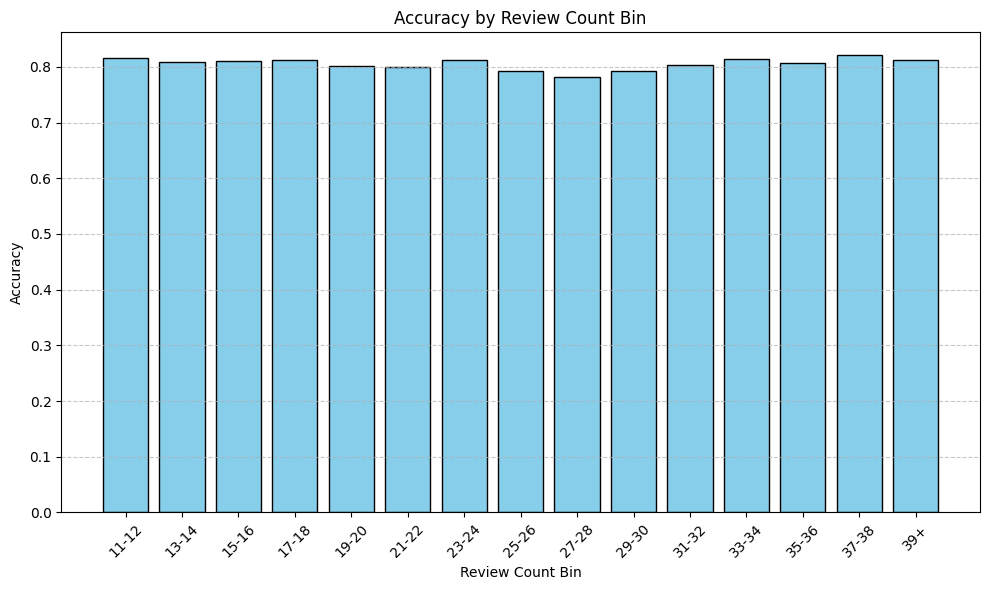

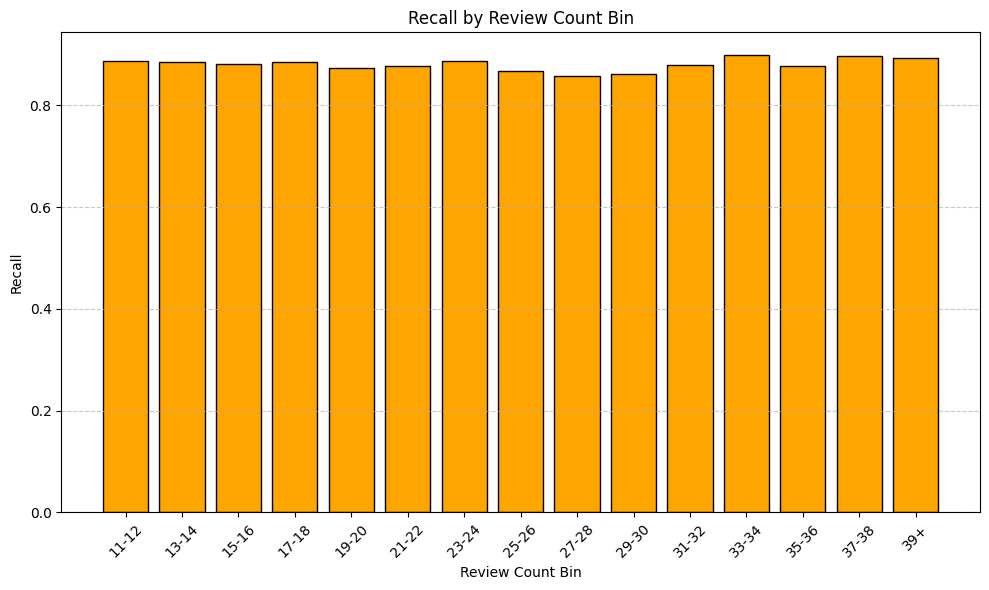

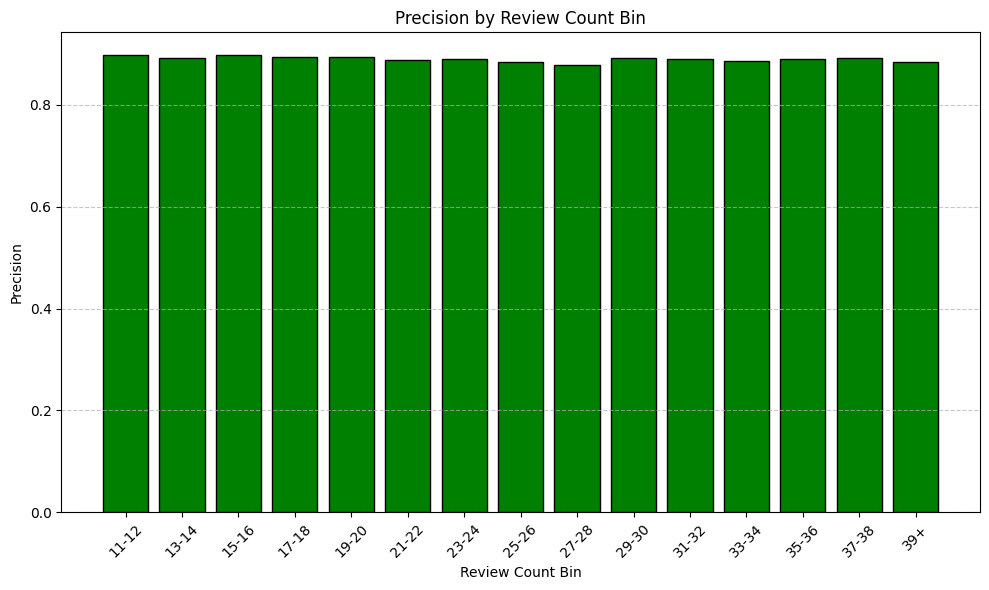

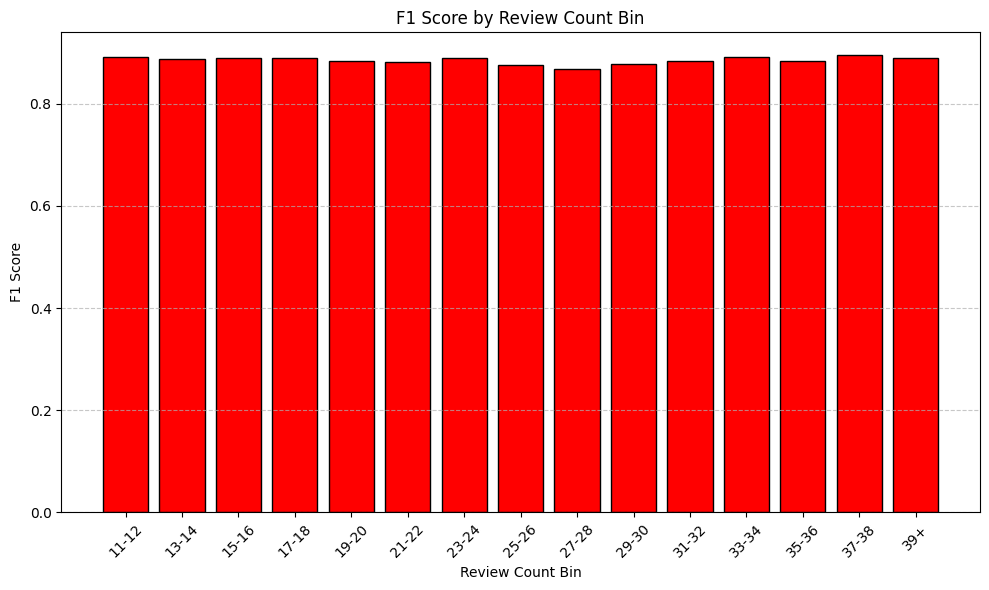

In [ ]:
# Calculate RMSE
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator
from pyspark.ml.feature import Bucketizer
import pandas as pd
import numpy as np

rounded_pred_review_count = rounded_pred.drop("review_count")\
    .join(reviews_by_user, on="author_steamid", how="inner").cache()

# Step 1: Define splits for bins
splits = list(np.arange(1, 40, 1)) + [float('inf')]

# Step 2: Generate dynamic bin labels
bin_labels = [
    f"{int(splits[i])}-{int(splits[i+1]) - 1}" if splits[i+1] != float('inf') else f"{int(splits[i])}+"
    for i in range(len(splits) - 1)
]

# Create a mapping of bin index to label and a sorting order
bin_sort_order = {i: label for i, label in enumerate(bin_labels)}

# Step 3: Apply Bucketizer
bucketizer = Bucketizer(
    splits=splits,
    inputCol="review_count",
    outputCol="review_count_bin"
)

binned_df = bucketizer.transform(rounded_pred_review_count)

# Map bin indices to dynamic labels
def map_bins(bin_index):
    return bin_sort_order.get(int(bin_index), "Unknown")

map_bins_udf = F.udf(map_bins, StringType())

binned_df = binned_df.withColumn(
    "review_count_bin_label",
    map_bins_udf(F.col("review_count_bin"))
)

# Step 4: Aggregate metrics by bin
metrics_df = binned_df.groupBy("review_count_bin_label").agg(
    F.count(F.when((F.col("prediction") == 1) & (F.col("rating") == 1), 1)).alias("TP"),
    F.count(F.when((F.col("prediction") == 1) & (F.col("rating") == -1), 1)).alias("FP"),
    F.count(F.when((F.col("prediction") == -1) & (F.col("rating") == 1), 1)).alias("FN"),
    F.count(F.when((F.col("prediction") == -1) & (F.col("rating") == -1), 1)).alias("TN")
)

# Collect metrics and calculate performance measures
metrics_collected = metrics_df.collect()

metrics_results = []
for row in metrics_collected:
    bin_label = row["review_count_bin_label"]
    TP = row["TP"]
    FP = row["FP"]
    FN = row["FN"]
    TN = row["TN"]

    accuracy = (TP + TN) / (TP + FP + FN + TN) if (TP + FP + FN + TN) > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    metrics_results.append((bin_label, accuracy, precision, recall, f1_score))

# Step 5: Convert to Pandas and sort by bin order
metrics_results_df = pd.DataFrame(
    metrics_results, 
    columns=["Review Count Bin", "Accuracy", "Precision", "Recall", "F1"]
)
metrics_results_df["SortOrder"] = metrics_results_df["Review Count Bin"].map(
    {v: k for k, v in bin_sort_order.items()}
)
metrics_results_df = metrics_results_df.sort_values("SortOrder").drop(columns=["SortOrder"])

# Step 6: Plot metric results
plt.figure(figsize=(10, 6))
plt.bar(metrics_results_df["Review Count Bin"], metrics_results_df["Accuracy"], color="skyblue", edgecolor="black")
plt.title("Accuracy by Review Count Bin")
plt.xlabel("Review Count Bin")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(metrics_results_df["Review Count Bin"], metrics_results_df["Recall"], color="orange", edgecolor="black")
plt.title("Recall by Review Count Bin")
plt.xlabel("Review Count Bin")
plt.ylabel("Recall")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(metrics_results_df["Review Count Bin"], metrics_results_df["Precision"], color="green", edgecolor="black")
plt.title("Precision by Review Count Bin")
plt.xlabel("Review Count Bin")
plt.ylabel("Precision")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(metrics_results_df["Review Count Bin"], metrics_results_df["F1"], color="red", edgecolor="black")
plt.title("F1 Score by Review Count Bin")
plt.xlabel("Review Count Bin")
plt.ylabel("F1 Score")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


# Content based filtering

### Using Euclidean distance

In [23]:
# Select relevant columns for content-based filtering
game_data = games\
    .where(games.detailed_description.isNotNull())\
    .select("app_id", "name", "genres", "publishers", "detailed_description")

# Preprocessing pipeline
# Tokenize the detailed description
tokenizer = Tokenizer(inputCol="detailed_description", outputCol="tokens")

# Remove stopwords
stopwords_remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")

# Apply TF (Term Frequency)
hashing_tf = HashingTF(inputCol="filtered_tokens", outputCol="raw_features", numFeatures=20)

# Apply IDF (Inverse Document Frequency)
idf = IDF(inputCol="raw_features", outputCol="text_features")

genres_vectorizer = CountVectorizer(inputCol="genres", outputCol="genres_vector", binary=True)
publishers_vectorizer = CountVectorizer(inputCol="publishers", outputCol="publishers_vector", binary=True)

vector_assembler = VectorAssembler(
    inputCols=["text_features", "genres_vector", "publishers_vector"],
    outputCol="features"
)

# Locality Sensitive Hashing (LSH) for similarity search
brp = BucketedRandomProjectionLSH(inputCol="features", outputCol="hashes", bucketLength=10.0)

# Build the pipeline
pipeline = Pipeline(stages=[
    tokenizer,
    stopwords_remover,
    hashing_tf,
    idf,
    genres_vectorizer,
    publishers_vectorizer,
    vector_assembler,
    brp
])

In [ ]:
explicit_model = pipeline.fit(game_data)

In [ ]:
result = explicit_model.transform(game_data)

In [ ]:
brp_model: BucketedRandomProjectionLSHModel = explicit_model.stages[-1]

In [27]:
query_vector = result\
    .where(F.col('app_id') == 80)\
    .select('features')\
    .first()["features"]

brp_model\
    .approxNearestNeighbors(
        dataset=result, 
        key=query_vector,
        numNearestNeighbors=30,
        distCol="EuclideanDistance" 
    )\
    .show(30, truncate=False)

+-------+------------------------------+----------------------+------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [28]:
left = result.alias("left")
right = result.alias("right")

similar_games = brp_model\
    .approxSimilarityJoin(
        left, right, threshold=0.0, distCol="EuclideanDistance"
    )\
    .filter(F.col("datasetA.app_id") < F.col("datasetB.app_id"))\
    
similar_games\
    .select(
        "datasetA.app_id",
        "datasetB.app_id",
        "EuclideanDistance"
    ).show()



ERROR:root:KeyboardInterrupt while sending command.                 (0 + 2) / 2]
Traceback (most recent call last):
  File "/Users/esben/dev/dtu/03semester/CTFDS/DTU-CTFDS-02807-PROJ/.venv/lib/python3.13/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/Users/esben/dev/dtu/03semester/CTFDS/DTU-CTFDS-02807-PROJ/.venv/lib/python3.13/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ~~~~~~~~~~~~~~~~~~~~^^
  File "/opt/homebrew/Cellar/python@3.13/3.13.0_1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/socket.py", line 719, in readinto
    return self._sock.recv_into(b)
           ~~~~~~~~~~~~~~~~~~~~^^^
KeyboardInterrupt


KeyboardInterrupt: 

In [30]:
games.printSchema()

root
 |-- app_id: long (nullable = true)
 |-- name: string (nullable = true)
 |-- release_date: date (nullable = true)
 |-- required_age: integer (nullable = true)
 |-- price: float (nullable = true)
 |-- dlc_count: integer (nullable = true)
 |-- detailed_description: string (nullable = true)
 |-- about_the_game: string (nullable = true)
 |-- short_description: string (nullable = true)
 |-- reviews: string (nullable = true)
 |-- header_image: string (nullable = true)
 |-- website: string (nullable = true)
 |-- support_url: string (nullable = true)
 |-- support_email: string (nullable = true)
 |-- windows: boolean (nullable = true)
 |-- mac: boolean (nullable = true)
 |-- linux: boolean (nullable = true)
 |-- metacritic_score: integer (nullable = true)
 |-- metacritic_url: string (nullable = true)
 |-- achievements: integer (nullable = true)
 |-- recommendations: integer (nullable = true)
 |-- notes: string (nullable = true)
 |-- supported_languages: array (nullable = true)
 |    |-- el

## Using Jaccard similarity

In [31]:
# Select relevant columns for content-based filtering
game_data = games\
    .filter(games.tags.isNotNull())\
    .filter(games.detailed_description.isNotNull())\
    .select("app_id", "name", "genres", "publishers", "detailed_description", "tags")

# Preprocessing pipeline
# Tokenize the detailed description
tokenizer = Tokenizer(inputCol="detailed_description", outputCol="tokens")

# Remove stopwords
stopwords_remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")

# Apply TF (Term Frequency)
hashing_tf = HashingTF(inputCol="filtered_tokens", outputCol="raw_features", numFeatures=1000)

# Apply IDF (Inverse Document Frequency)
idf = IDF(inputCol="raw_features", outputCol="text_features")

genres_vectorizer = CountVectorizer(inputCol="genres", outputCol="genres_vector", binary=True)
publishers_vectorizer = CountVectorizer(inputCol="publishers", outputCol="publishers_vector", binary=True)

# Convert tags (Map<String, Int>) into feature vector
# Extract keys and values from the tags map
tags_keys = F.map_keys(game_data.tags)
tags_values = F.map_values(game_data.tags)

# Create a DataFrame with tag names (keys) and their respective weights (values)
game_data = game_data\
    .withColumn("tags_keys", tags_keys)\
    .withColumn("tags_values", tags_values)

# Use CountVectorizer to convert the tag keys into a feature vector
tags_vectorizer = CountVectorizer(inputCol="tags_keys", outputCol="tags_key_features")

vector_assembler = VectorAssembler(
    inputCols=["text_features", "genres_vector", "publishers_vector", "tags_key_features"],
    outputCol="features"
)

# Locality Sensitive Hashing (LSH) for similarity search
minhash_lsh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=10)

# Build the pipeline
pipeline = Pipeline(stages=[
    tokenizer,
    stopwords_remover,
    hashing_tf,
    idf,
    genres_vectorizer,
    publishers_vectorizer,
    tags_vectorizer,
    vector_assembler,
    minhash_lsh
])


In [ ]:
# Fit the pipeline to the data
explicit_model = pipeline.fit(game_data)
processed_games_df = explicit_model.transform(game_data)

In [ ]:
# Show the processed data
# processed_games_df.select("app_id", "name", "hashes").show(truncate=False)

# Example: Finding similar games based on detailed description
# Choose a game to find similar ones

# FIFA 23 = 1811260
# Counter Strike Zero = 80
# Garry's Mod = 4000

sample_game = processed_games_df.filter(games.app_id == 80).limit(1)
sample_game_features = sample_game.select("features").first()["features"]

sample_game.show(truncate=False)

mh_model: MinHashLSHModel = explicit_model.stages[-1]

# Perform the similarity search
mh_model.approxNearestNeighbors(
    dataset=processed_games_df, key=sample_game_features, numNearestNeighbors=20, distCol="JaccardDistance"
)\
    .orderBy(F.asc("JaccardDistance"))\
    .show(truncate=False)

# similar_games = mh_model.approxSimilarityJoin(
#     processed_games_df, sample_game, 2.0, distCol="JaccardDistance"
# )

# # Show similar games
# similar_games\
#     .select("datasetA.name", "datasetB.name", "JaccardDistance")\
#     .orderBy(F.asc("JaccardDistance"))\
#     .show(truncate=False)

+------+------------------------------+--------+----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------

+-------+------------------------------+--------------------------------------------------------------+-----------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------

24/11/21 11:59:57 ERROR Inbox: Ignoring error                       (0 + 2) / 2]
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apach